### <font color=darkred size=6 > ABOUT THIS PROJECT </font>

In this project, I build from scratch a deep neural network pre-trained (or not) for the classification of handwritten digits. The main goal is to compare the performances, in terms of good classification rates, of a pre-trained network and a randomly initialized network, according to the input data, the number of network layers and finally the number of neurons per layer. In the last section, we try to determine the architechture and hyperparameters giving the lowest classification error rate. 

# Overview


1. [Getting Started : setup](#Getting-Started)

2. [Binary AlphaDigits](#Preprocessing)   

3. [Handwritten digit with MNIST](#Exploring-the-data)

4. [Restricted Boltzman Machine](#the-study)
  * [Train RBM](#)
  * [Generate images with RBM](#generate)
    
5. [Pretrain a Deep Belief Network & Deep Neural Network ](#)
  * [Pretraining](#)   
  * [Generate imgaes](#) 
  * [Backpropagation](#) 
      

6.  [Performance evaluation](#)
  * [ Error rates as a function of the number of hidden layers ](#)
  * [ Error rates as a function of the number of neurons per layer](#)
  * [ Error rates as a function of input data size](#)
  * [ Hyperparameters tuning](#)

### <font color=darkred size=6 > SETUP </font>

In [ ]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.special import expit
import warnings
from tqdm import tqdm
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 7)})
warnings.filterwarnings("ignore")

Set up google drive environment in order to access the BinaryAlphadigit dataset

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Load dataset from google drive

In [ ]:
id = '11frDXFE_ZthYM209AhahzrNvA0TLhOnC'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('binaryalphadigs.mat')

In [ ]:
import scipy.io as dd
mat = dd.loadmat('binaryalphadigs.mat')
data = mat['dat']

### <font color=darkred size=6 > Binary AlphaDigits </font>

The **lire_alpha_digit** function allows to retrieve data in a matrix form. It takes in argument the characters that we want to learn. To be more precise,  characters' indexes are the argument of the function.

In [ ]:
def lire_alpha_digit(*args):
  alpha_digits = []
  for arg in args:
    for i in range(39):
      alpha_digits.append(data[arg][i].flatten())
  return np.array(alpha_digits)

In [ ]:
alpha = lire_alpha_digit(10,11,35)

In [ ]:
alpha.shape

(117, 320)

---
The function **afficher_image** will plot the images generated by our models.

In [ ]:
def afficher_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

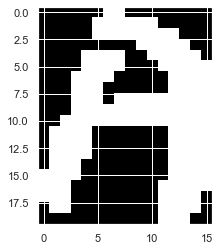

In [ ]:
afficher_image(alpha[0].reshape(20,16))

---

### <font color=darkred size=6 > Handwritten digit with MNIST</font>

We will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 

These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image can be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. We will transform in black and white.

We will define a certain threshold. If pixels are less than this threshold, it corresponds to 0 otherwise we replace them by 1. 

In [ ]:
import keras
from keras import backend as K
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


#We set a threshold to 129

threshold = 129
def grayscale_to_black_white(X):
  XX = np.empty_like(X)
  XX[X< threshold] = 0
  XX[X>=threshold] = 1
  XX = XX.reshape(*XX.shape, 1) 
  return XX

# Load the data

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = grayscale_to_black_white(X_train)
X_test = grayscale_to_black_white(X_test)

num_train  = X_train.shape[0]
num_test   = X_test.shape[0]
img_height = X_train.shape[1]
img_width  = X_train.shape[2]
X_train = X_train.reshape((num_train, img_width * img_height))
X_test  = X_test.reshape((num_test, img_width * img_height))

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using TensorFlow backend.


X_train shape: (60000, 784)
X_test shape: (10000, 784)
y_train shape: (60000,)
y_test shape: (10000,)


In the next cell we illustrate the first four elements of the training data: 
pixels of the digit and their corresponding label.

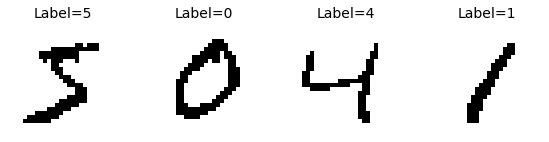

In [ ]:
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

Here is a glimpse of the digits without their labels

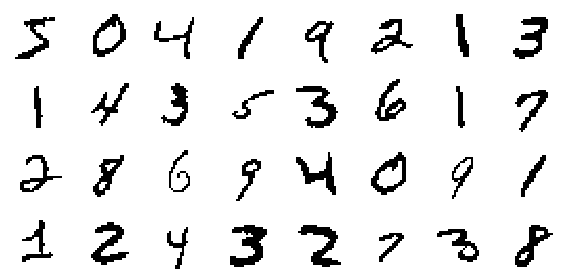

In [ ]:
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

We need to one-hot encode the labels

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


### <font color=darkred size=6 > RBM class : train and generate images </font>



<img src="https://paperswithcode.com/media/methods/1_Z-uEtQkFPk7MtbolOSUvrA_qoiHKUX.png" class="center" style="width: 600px; max-width: 100%; height: auto" title="Restricted Boltzman Machine." />

Image source : https://paperswithcode.com/method/restricted-boltzmann-machine

**Restricted Boltzman Machines** are generative networks composed of two layers : a visible layer and hidden layer. RBM's networks learn a probability distribution over given inputs. Each one of visible layer nodes is connected to the hidden layer nodes. Connections between nodes are unidirected.

We compute in this section a ***Restricted Boltzman Machine*** class to train and generate digits images. We start by initializing the bias/weight of the RBM. The visible and hidden bias are initialized to 0 and the weights are randomly initialized according to centered normal distribution with a variance equal to 0.01. 

The function **entree_sortie_RBM** compute the output units value with the sigmoid function given a RBM and the input data as arguments whereas **sortie_entree_RBM** function takes as argument a RBM, output data and returns the value of the input units from the sigmoid function.

Once parameters are initialized, we learn the RBM in an unsupervised way using the Contrastive-Divergence-1 algorithm.

#### <font size=5 > Train RBM </font>

In [ ]:
#Compute sigmoid 
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class RBM(object):
    
    """Restricted Boltzmann Machine (RBM)  """
    
    ##Randomly initialized the RBM weights and biais

    def __init__(self, n_hidden, n_visible):    
      self.n_hidden = n_hidden
      self.n_visible = n_visible
      self.a = np.zeros((1, self.n_visible))
      self.b = np.zeros((1, self.n_hidden))
      self.w = np.random.normal(0, 0.1, size=(self.n_visible, self.n_hidden))

    #compute output units given a RBM and input data    
    def entree_sortie_RBM(self,x):
      proba = expit(self.b + np.dot(x, self.w))
      return proba

    #Compute input units value given a RBM and the output data
    def sortie_entree_RBM(self, h):
      proba = expit(self.a + np.dot(h, self.w.T))
      return proba 
    
    #Learn the RBM's weights and bias

    def train_RBM(self, X,learning_rate, epochs, batch_size):
      #get batches
      batches = []
      n=np.shape(X)[0]
      for i in range(0, n, batch_size):
        batches.append(X[i:i + batch_size])
      for epoch in range(epochs):
        for mini_batch in range(len(batches)):
          v0 = np.copy(batches[mini_batch])

          prob_h_given_v0 = self.entree_sortie_RBM(v0)
          h0 = (np.random.uniform(0,1,size=prob_h_given_v0.shape) < prob_h_given_v0)*1            
          prob_v_given_h0 = self.sortie_entree_RBM(h0)
          v1 = (np.random.uniform(0,1,size=prob_v_given_h0.shape) < prob_v_given_h0)*1          
          prob_h_given_v1 = self.entree_sortie_RBM(v1)
          h1 = (np.random.uniform(0,1,size=prob_h_given_v1.shape) < prob_h_given_v1)*1

          #Compute gradients
          delta_w = (np.dot(prob_h_given_v0.T, v0) - np.dot(prob_h_given_v1.T, v1)).transpose()
          delta_a = np.sum(v0, axis=0) - np.sum(v1, axis=0)
          delta_b = np.sum(h0, axis=0) - np.sum(h1, axis=0)

            
          # Updata weights and bias   
          self.w += (learning_rate/len(v0))*delta_w
          self.b += (learning_rate/len(v0))*delta_b
          self.a += (learning_rate/len(v0))*delta_a

        #Compute reconstruction mean square error
        h = self.entree_sortie_RBM(X)
        X_reconstructed = self.sortie_entree_RBM(h)
        error = np.mean((X - X_reconstructed) ** 2)  
        print("Epoch %s completed. Reconstructed Error is %0.2f." % (epoch + 1, error))  
      return self

    #Compute a function that regenerate an image
    def generer_image_RBM(self, nb_iterations, nb_images): 
      dim_v=np.shape(self.w)[0]
      v = np.random.randint(low = 0, high = 2, size = (nb_images, dim_v))
      prob_h_given_v = self.entree_sortie_RBM(v)
      h = (prob_h_given_v > np.random.uniform(0, 1, size = prob_h_given_v.shape))*1
      for i in range(nb_iterations):
        prob_v_given_h = self.sortie_entree_RBM(h)
        v = (prob_v_given_h > np.random.uniform(0, 1, size = prob_v_given_h.shape))*1
        prob_h_given_v = self.entree_sortie_RBM(v)
        h= (prob_h_given_v > np.random.uniform(0, 1, size = prob_h_given_v.shape))*1
      return v

In the following scripts, we define a RBM object by calling on the above class, we train it and generate the binary alpha digits images. At each epochs, we print the reconstruction mean square error to verify if it decreases.

In [ ]:
image = alpha
n_visible = 320
n_hidden = 320
learning_rate = 0.01
epochs = 50
batch_size = 4
birdi = RBM(n_visible, n_hidden)

In [ ]:
birdi.train_RBM(image,learning_rate, epochs, batch_size)

Epoch 1 completed. Reconstructed Error is 0.19.
Epoch 2 completed. Reconstructed Error is 0.16.
Epoch 3 completed. Reconstructed Error is 0.14.
Epoch 4 completed. Reconstructed Error is 0.13.
Epoch 5 completed. Reconstructed Error is 0.12.
Epoch 6 completed. Reconstructed Error is 0.11.
Epoch 7 completed. Reconstructed Error is 0.11.
Epoch 8 completed. Reconstructed Error is 0.10.
Epoch 9 completed. Reconstructed Error is 0.10.
Epoch 10 completed. Reconstructed Error is 0.10.
Epoch 11 completed. Reconstructed Error is 0.09.
Epoch 12 completed. Reconstructed Error is 0.09.
Epoch 13 completed. Reconstructed Error is 0.09.
Epoch 14 completed. Reconstructed Error is 0.08.
Epoch 15 completed. Reconstructed Error is 0.08.
Epoch 16 completed. Reconstructed Error is 0.08.
Epoch 17 completed. Reconstructed Error is 0.08.
Epoch 18 completed. Reconstructed Error is 0.08.
Epoch 19 completed. Reconstructed Error is 0.07.
Epoch 20 completed. Reconstructed Error is 0.07.
Epoch 21 completed. Reconstru

#### <font  size=5 > Generate images with RBM</font>

In [ ]:
nb_iterations, nb_images = 1000, 5 
img = birdi.generer_image_RBM(nb_iterations, nb_images)

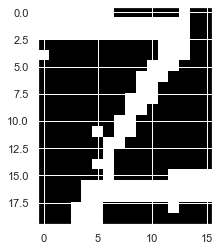

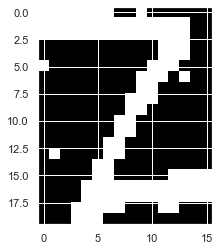

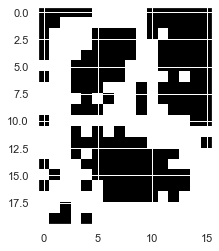

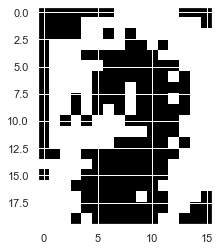

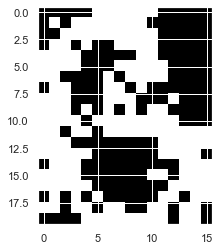

In [ ]:
for i in range(nb_images):
    afficher_image(img[i].reshape(20,16))
#afficher_image(img)

### <font color=darkred size=6 > Pretrain a Deep Belief Network & Deep Neural Network </font>

Deep Belief Networks are neural networks that consist of stacked RBMs

<img src="https://i.imgur.com/CodLXbO.png" class="center" style="width: 700px; max-width: 100%; height: auto" title="Restricted Boltzman Machine." />

In [ ]:
class DBN(object):

  #Initialize weights and bias and all layers (including our DNN classification layer)

  def __init__(self, nb_per_layers):
  
    self.nb_per_layers = nb_per_layers
    self.rbm_layers = []
    for i in range(len(self.nb_per_layers)-1):
      self.rbm_layers.append(RBM(self.nb_per_layers[i+1], self.nb_per_layers[i]))

  def pretrain_DNN(self, X,learning_rate, epochs, batch_size): 
    
    for i in range(len(self.rbm_layers)-1):
      size_entree_couche_k_plus_1=np.shape(self.rbm_layers[i+1].a)[1]
      size_sortie_couche_k=np.shape(self.rbm_layers[i].b)[1]
      assert size_entree_couche_k_plus_1==size_sortie_couche_k, "Il faut que taille RBM K+1 = taille sortie du RBM K"

    #We do not learn the mast RBM (classification layer)
    self.trained_DNN = []
    n_layers = len(self.rbm_layers) - 1
    self.trained_DNN.append(self.rbm_layers[0].train_RBM(X,learning_rate, epochs, batch_size))
    for i in range(1, n_layers):
      H=[]
      prob_h_given_v = self.trained_DNN[0].entree_sortie_RBM(X)
      h = (prob_h_given_v < np.random.uniform(0, 1, size = prob_h_given_v.shape))*1
      H.append(h)
      for k in range(1, i):
        prob_hk_given_hk_1 = self.trained_DNN[k].entree_sortie_RBM(H[-1])  
        hk = (prob_hk_given_hk_1 < np.random.uniform(0,1,size=prob_hk_given_hk_1.shape))*1
        H.append(hk)  
      self.trained_DNN.append(self.rbm_layers[i].train_RBM(H[-1], learning_rate, epochs, batch_size))
    
    #Append the output layer that was not learned
    self.trained_DNN.append(self.rbm_layers[-1])
    return self.trained_DNN

#### <font  size=5 > Generate images with DBN </font>

In [ ]:
def generer_images_DBN(trained_DNN, nb_iter_gibbs, nb_images):
    
    """
    Generate images with a pretrain DNN
    We do not take intot account the last RBM (our DNN classification layer)
    """
    #make a copy just to avoid modifying our list of RBM.
    DNN = trained_DNN.copy() 
    DNN.pop()
    RBM=DNN[-1]
    dim_h_P_1=RBM.w.shape[0]  
    
    #v is layer P-1 (we have P layers)
    h_p_1=(np.random.uniform(0,1,size=(nb_images,dim_h_P_1))<0.5)*1   
    prob_h_p_given_h_p_1=RBM.entree_sortie_RBM(h_p_1)
    h_p=(prob_h_p_given_h_p_1 > np.random.uniform(0,1,size=prob_h_p_given_h_p_1.shape))*1

    for g in range(nb_iter_gibbs):       
        prob_h_p_1_given_h_p=RBM.sortie_entree_RBM(h_p)
        h_p_1=(prob_h_p_1_given_h_p > np.random.uniform(0,1,size=prob_h_p_1_given_h_p.shape))*1
        prob_h_p_given_h_p_1 = RBM.entree_sortie_RBM(h_p_1)
        h_p=(prob_h_p_given_h_p_1 > np.random.uniform(0,1,size=prob_h_p_given_h_p_1.shape))*1
        
    H=[h_p_1]
    for k in range(len(DNN)-2,-1,-1):    
        prob_hk_1_given_hk=DNN[k].sortie_entree_RBM(H[-1])
        hk_1=(prob_hk_1_given_hk > np.random.uniform(0,1,size=prob_hk_1_given_hk.shape))*1
        H.append(hk_1)     
    matrice_images=H[-1]
    return(matrice_images)

In the following cell, we learn a DBN and generate the binary alpha digits images.

In [ ]:
DNN_object = DBN([320,320,320,320,320])

trained_DNN = DNN_object.pretrain_DNN(image, 0.01, 50, 4)

Epoch 1 completed. Reconstructed Error is 0.19.
Epoch 2 completed. Reconstructed Error is 0.16.
Epoch 3 completed. Reconstructed Error is 0.14.
Epoch 4 completed. Reconstructed Error is 0.13.
Epoch 5 completed. Reconstructed Error is 0.12.
Epoch 6 completed. Reconstructed Error is 0.11.
Epoch 7 completed. Reconstructed Error is 0.11.
Epoch 8 completed. Reconstructed Error is 0.10.
Epoch 9 completed. Reconstructed Error is 0.10.
Epoch 10 completed. Reconstructed Error is 0.09.
Epoch 11 completed. Reconstructed Error is 0.09.
Epoch 12 completed. Reconstructed Error is 0.09.
Epoch 13 completed. Reconstructed Error is 0.09.
Epoch 14 completed. Reconstructed Error is 0.08.
Epoch 15 completed. Reconstructed Error is 0.08.
Epoch 16 completed. Reconstructed Error is 0.08.
Epoch 17 completed. Reconstructed Error is 0.08.
Epoch 18 completed. Reconstructed Error is 0.08.
Epoch 19 completed. Reconstructed Error is 0.07.
Epoch 20 completed. Reconstructed Error is 0.07.
Epoch 21 completed. Reconstru

In [ ]:
nb_iter_gibbs, nb_images = 1000, 2
img_DNN = generer_images_DBN(trained_DNN, nb_iter_gibbs, nb_images)

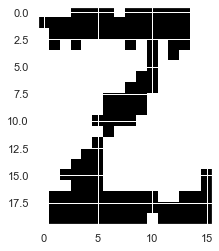

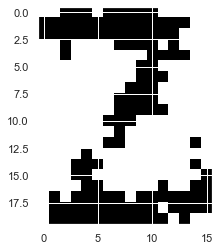

In [ ]:
for i in range(nb_images):
    afficher_image(img_DNN[i].reshape(20,16))

### Divide input data in m batches

We will compute to functions that can be used to divide our datasets in batches. In the second one we shuffled and randomly pick elements to create batches of the inputs whereas the first functions just loops by the batch_size.

In [ ]:
def get_batches_first_example(X, label, batch_size):
  X_batches, label_batches = [], []
  for i in range(0, X.shape[0], batch_size):
    X_batches.append(X[i:i + batch_size])
    label_batches.append(label[i:i + batch_size])
  return X_batches, label_batches

Second approach


In [ ]:
def get_batches_second_example(x, x_labels, batch_size):
  np.random.seed()
  n = len(x)
  nb_batches = n//batch_size
  permutations = list(np.random.permutation(n))
  x_shuffled = x[permutations, :]
  x_labels_shuffled = x_labels[permutations, :]
  x_mini_batches = []
  x_labels_mini_batches = []
  for k in range(nb_batches):
    x_mini_batch = x_shuffled[batch_size * k : (batch_size * (k + 1)), :]
    x_labels_mini_batch = x_labels_shuffled[batch_size * k : (batch_size * (k + 1)), :]
    x_mini_batches.append(x_mini_batch)
    x_labels_mini_batches.append(x_labels_mini_batch)
  if n%batch_size != 0 :
    x_mini_batch = x_shuffled[batch_size * nb_batches :, :]
    x_labels_mini_batch = x_labels_shuffled[batch_size * nb_batches :, :]
    x_mini_batches.append(x_mini_batch)
    x_labels_mini_batches.append(x_labels_mini_batch)
  return x_mini_batches, x_labels_mini_batches

### Fonction softmax

The **calcul_softmax** function takes as argument an RBM, input data and returns probabilities on the output units.


The formula of the softmax function $\sigma(x)$ for a vector
$x=\left\{x_{0}, x_{1}, \ldots, x_{n-1}\right\}$ is
$$
\sigma(x)_{j}=\frac{e^{x_{j}}}{\sum_{k} e^{x_{k}}}
$$

In [ ]:
def calcul_softmax(rbm, X):
  return (np.exp(rbm.b + np.dot(X, rbm.w)).T / np.sum(np.exp(rbm.b + np.dot(X, rbm.w)),axis=1)).T

In [ ]:
calcul_softmax(birdi, X)

array([[4.28575371e-03, 4.00892105e-04, 2.83838295e-05, ...,
        1.17635261e-04, 1.59690663e-03, 8.48505417e-04],
       [1.63388774e-03, 4.49265181e-04, 1.65077437e-04, ...,
        1.87608270e-05, 8.63938687e-04, 1.14797167e-03],
       [5.84403305e-05, 4.16711303e-05, 5.77220770e-04, ...,
        1.52531929e-03, 1.67164739e-03, 6.84428738e-04],
       ...,
       [6.18281264e-04, 1.16458424e-03, 1.42272844e-03, ...,
        4.89487440e-05, 4.93329985e-03, 1.43291863e-03],
       [6.72501916e-04, 4.14641685e-04, 2.08477604e-03, ...,
        1.05676594e-03, 2.52404737e-03, 5.40222546e-04],
       [3.47862196e-03, 5.06606814e-06, 4.15330680e-06, ...,
        2.32778494e-04, 1.62158314e-03, 4.82251902e-04]])

### Entree sortie reseau

This function takes as argument a DNN and input data and returns the outputs on each hidden layer of the network as well as the output units' probabilities.

In [ ]:
def entree_sortie_reseau(dnn, X):
  hidden_layers_output = [X]
  #First hidden layer output
  hidden_layers_output.append(dnn[0].entree_sortie_RBM(X))
  for i in range(1, len(dnn)-1):
    layer_k_ = dnn[i].entree_sortie_RBM(hidden_layers_output[-1])
    hidden_layers_output.append(layer_k_)
  proba = calcul_softmax(dnn[-1], hidden_layers_output[-1])
  return hidden_layers_output, proba

### Rétropropagation

In this section, we compute the backpropagation algorithm used to train our neural networks. Function ***backpropagation()*** takes as argument a DNN, the number of iterations of the gradient descent, the learning rate, the batchsize, input data and their label.

In [ ]:
from sklearn.metrics import log_loss

def backpropagation(dnn, epochs, learning_rate, batch_size, X, label):
  
  #get batches 
  X_batches, label_batches = get_batches_second_example(X, label, batch_size)

  nb_batches = len(X_batches)
  cross_entropy = []
  for epoch in range(epochs):
    cross_entropy_epoch = 0
    for i in range(nb_batches):
      delta_W = []
      delta_bias = []
      hidden_layers, Y = entree_sortie_reseau(dnn, X_batches[i])
      Y_lab = label_batches[i]
      cross_entropy_epoch += log_loss(Y_lab, Y)
      C = Y - Y_lab
      delta_W.append(np.dot(hidden_layers[-1].T, C))
      delta_bias.append(np.sum(C, axis=0))

      for k in range(len(dnn) - 2, -1, -1):
        C = np.dot(C, dnn[k+1].w.T)*hidden_layers[k+1]*(1-hidden_layers[k+1])
        delta_W.append(np.dot(hidden_layers[k].T, C))
        delta_bias.append(np.sum(C, axis=0))

      delta_W.reverse()    
      delta_bias.reverse()
      
      #Update weights and bias

      for j in range(len(dnn)):
        dnn[j].w -= (learning_rate/len(X_batches[i]))*delta_W[j]
        dnn[j].b -= (learning_rate/len(X_batches[i]))*delta_bias[j]  

    cross_entropy.append(cross_entropy_epoch/nb_batches)  
  return dnn, cross_entropy

In the following cells, we test the backpropagation algorithm with a pretrained DNN : 2 hidden layers of 200 neurons. We plot the cross entropy as a function of epochs and see if it converge and compute the error rate. 

In [ ]:
#Pretain and train DNN
%%capture
DNN = DBN([784,200,200,10]).pretrain_DNN(X_train, 0.1, 100, 128)
DNN_back, entropy = backpropagation(DNN, 200, 0.1, 128, X_train, y_train)

Plot the cross entropy

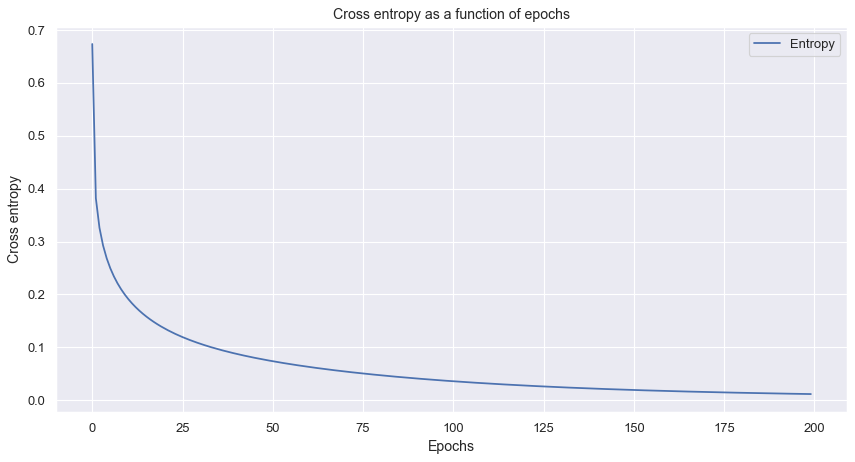

In [ ]:
plt.figure(figsize=(12,6), dpi=85)
plt.plot([i for i in range(200)], entropy, label='Entropy')
plt.title("Cross entropy as a function of epochs")
plt.xlabel('Epochs')
plt.ylabel('Cross entropy')
plt.legend()
plt.show()

### Test DNN

This function computes the classification error rate. It takes in a DNN, input data et its corresponding labels as arguments. It will help us assess the performance of our neural networks and compare them. 

In [ ]:
def test_DNN(DNN_pretrained, x_test, labels):
  error_rate = 0
  output = entree_sortie_reseau(DNN_pretrained, x_test)[1]
  estimated_labels = np.argmax(output, axis=1)
  true_labels = np.argmax(labels, axis=1)
  for i in range(len(true_labels)):
    if estimated_labels[i] != true_labels[i]:
      error_rate += 1
  return error_rate/len(true_labels)

For the previous example, we compute the classification error rate with test_DNN

In [ ]:
test_DNN(DNN_back, X_test, y_test)

0.0247

### <font color=darkred size=6 > Compare the performance of a pretrain DNN and an unpretrained DNN </font>

In this section, we will analyze the performance of two Deep Neural Networks on MNIST dataset. The first DNN is pretrained and second one is randomly initialized network. We will follow the following steps :

* Initialize the two networks
* Pretrained one the networks by considering it as stacked RBMs
* Learn the pretrained DNN with the backpropagation algorithm
* Learn the unpretrained DNN with the backpropagation algorithm
* Compute the error rate for both networks


#### <font  size=5 > Error rates as a function of the number of hidden layers </font>

First, we compared the performance of the pre-trained neural network and the randomly initialized neural network, based on the number of layers and setting the number of neurons per layer at 200. 

In [ ]:
epoch_back = 200
epoch_pretrain = 100
lr = 0.1
batch = 120
layers = [[784,200,200,10], [784,200,200,200,10], [784,200,200, 200, 200, 10], [784, 200, 200, 200, 200, 200,10]]
#error rate for untrained DNN
error_untrained_1 = []   
#Pre-trained DNN error rate
error_pretrained_1 = []           

for l in tqdm(layers):
  #Untrained DNN
  DNN_1_untrained = DBN(l).rbm_layers
  DNN_1_untrained_backprop = backpropagation(DNN_1_untrained, epoch_back, lr, batch, X_train, y_train)[0]
  error_untrained_1.append(test_DNN(DNN_1_untrained_backprop, X_test, y_test))

  #Pretrained DNN
  DNN_1_pretrained = DBN(l).pretrain_DNN(X_train,lr, epoch_pretrain, batch)
  DNN_1_pretrained_backprop = backpropagation(DNN_1_pretrained, epoch_back, lr, batch, X_train, y_train)[0]
  error_pretrained_1.append(test_DNN(DNN_1_pretrained_backprop, X_test, y_test))

100%|██████████| 4/4 [3:27:39<00:00, 3114.94s/it]  


In [ ]:
errors_1 = {'Unpretrained' : error_untrained_1, 'Pretrained' : error_pretrained_1}
df_errors_1 = pd.DataFrame(errors_1)
df_errors_1

,Unpretrained,Pretrained
0,0.0255,0.0274
1,0.0277,0.0275
2,0.0313,0.0281
3,0.0329,0.0295


###### <font color=darkred size=4 > Figure 1 </font>

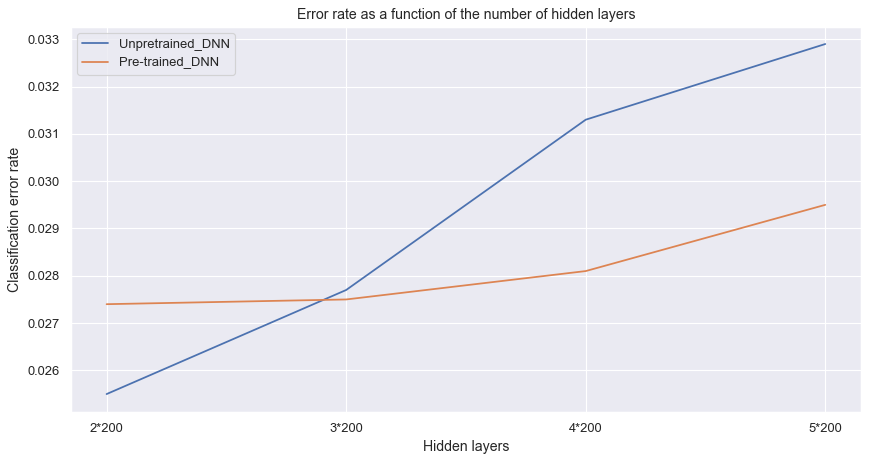

In [ ]:
plt.figure(figsize=(12,6), dpi=85)
plt.plot([str(i) + '*' + '200' for i in range(2,6)], error_untrained_1, label='Unpretrained_DNN')
plt.plot([str(i) + '*' + '200' for i in range(2,6)], error_pretrained_1, label='Pre-trained_DNN')
plt.title("Error rate as a function of the number of hidden layers")
plt.xlabel('Hidden layers')
plt.ylabel('Classification error rate')
plt.legend()
plt.show()

We can see that the lowest classification error is obtained with the pre-trained neural network. 
Moreover, for both models, when starting with 2 hidden layers, the addition of hidden layers does not provide us with better performances.

#### <font  size=5 > Error rates as a function of the number of neurons </font>

In this section, we compared the performance of the pre-trained neural network and the randomly initialized neural network, according to the number of neurons on the hidden layers. We set the number of the latter to two.

In [ ]:
epoch_back = 200
epoch_pretrain = 100
lr = 0.1
batch = 120
n_layers = [[784,100,100,10], [784,300,300,10], [784,500,500, 10], [784, 700,700, 10]]
#error rate for untrained DNN
error_unpretrained_2 = []   
#Pre-trained DNN error rate
error_pretrained_2 = []           

for l in tqdm(n_layers):
  #Untrained DNN
  DNN_2_untrained = DBN(l).rbm_layers
  DNN_2_untrained_backprop = backpropagation(DNN_2_untrained, epoch_back, lr, batch, X_train, y_train)[0]
  error_unpretrained_2.append(test_DNN(DNN_2_untrained_backprop, X_test, y_test))

  #Pretrained DNN
  DNN_2_pretrained = DBN(l).pretrain_DNN(X_train, lr, epoch_pretrain, batch)
  DNN_2_pretrained_backprop = backpropagation(DNN_2_pretrained, epoch_back, lr, batch, X_train, y_train)[0]
  error_pretrained_2.append(test_DNN(DNN_2_pretrained_backprop, X_test, y_test))

100%|██████████| 4/4 [6:33:21<00:00, 5900.37s/it]  


In [ ]:
errors = {'Unpretrained' : error_unpretrained_2, 'Pretrained' : error_pretrained_2}
df_errors = pd.DataFrame(errors)
df_errors

,Unpretrained,Pretrained
0,0.0277,0.0317
1,0.0241,0.0229
2,0.0242,0.0209
3,0.0241,0.0200


###### <font color=darkred size=4 > Figure 2 </font>

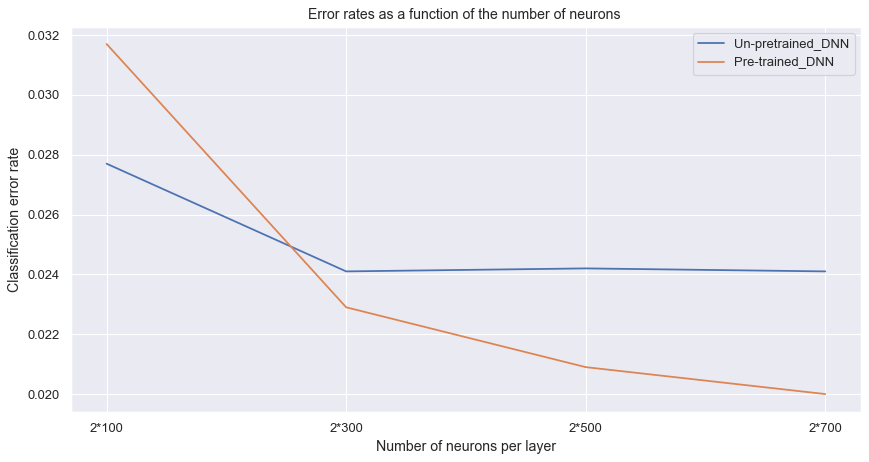

In [ ]:
plt.figure(figsize=(12,6), dpi=85)
plt.plot([str(2) + '*' + str(100*i) for i in range(1,8,2)], error_unpretrained_2, label='Un-pretrained_DNN')
plt.plot([str(2) + '*' + str(100*i) for i in range(1,8,2)], error_pretrained_2, label='Pre-trained_DNN')
plt.title("Error rates as a function of the number of neurons ")
plt.xlabel('Number of neurons per layer')
plt.ylabel('Classification error rate')
plt.legend()
plt.show()

It can be seen that here too, as in the previous figure, the non-pre-trained DNN is less efficient than the pre-trained DNN. The performance of the latter increases with the number of neurons in the hidden layers.

 #### <font  size=5 > Error rates as a function of input data dimension </font>

Finally, we compare the performance of the pre-trained neural network and the randomly initialized network, based on the number of training data and keeping two hidden layers of 200 neurons in each.

In [ ]:
epoch_back = 200
epoch_pretrain = 100
lr = 0.1
batch = 120
input_dimension = [1000, 3000, 7000, 10000, 30000, 60000]
layers = [784,700,700,10]
#error rate for untrained DNN
error_unpretrained_3 = []   
#Pre-trained DNN error rate
error_pretrained_3 = []           

for dim in tqdm(input_dimension):
  #Unpretrained DNN
  DNN_3_untrained = DBN(layers).rbm_layers
  DNN_3_untrained_backprop = backpropagation(DNN_3_untrained, epoch_back, lr, batch, X_train[:dim], y_train[:dim])[0]
  error_unpretrained_3.append(test_DNN(DNN_3_untrained_backprop, X_test, y_test))

  #Pretrained DNN
  DNN_3_pretrained = DBN(layers).pretrain_DNN(X_train[:dim],lr, epoch_pretrain, batch)
  DNN_3_pretrained_backprop = backpropagation(DNN_3_pretrained, epoch_back, lr, batch, X_train[:dim], y_train[:dim])[0]
  error_pretrained_3.append(test_DNN(DNN_3_pretrained_backprop, X_test, y_test))

100%|██████████| 6/6 [3:11:33<00:00, 1915.52s/it]


In [ ]:
errors_3 = {'Unpretrained' : error_unpretrained_3, 'Pretrained' : error_pretrained_3}
df_errors_3 = pd.DataFrame(errors_3)
df_errors_3

,Unpretrained,Pretrained
0,0.1446,0.1224
1,0.1170,0.0784
2,0.0900,0.0615
3,0.0771,0.0514
4,0.0342,0.0278
5,0.0261,0.0226


###### <font color=darkred size=4 > Figure 3 </font>

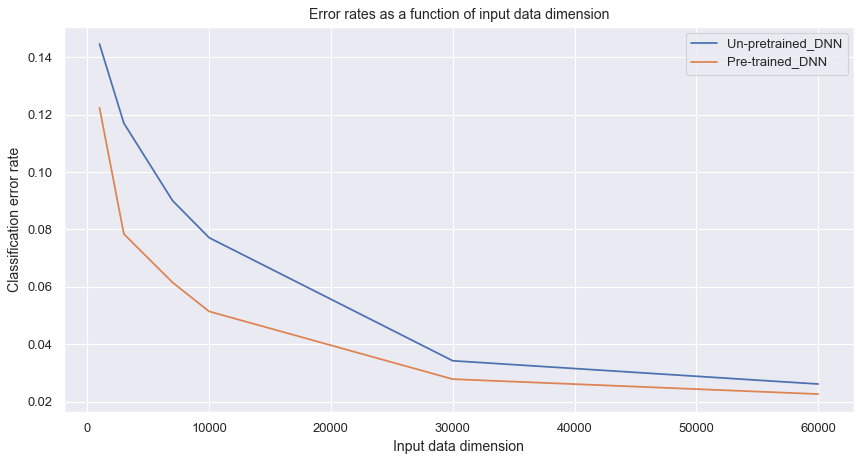

In [ ]:
plt.figure(figsize=(12,6), dpi=85)
plt.plot(input_dimension, error_unpretrained_3, label='Un-pretrained_DNN')
plt.plot(input_dimension, error_pretrained_3, label='Pre-trained_DNN')
plt.title("Error rates as a function of input data dimension")
plt.xlabel('Input data dimension')
plt.ylabel('Classification error rate')
plt.legend()
plt.show()

Up to now, the error rates we were getting with our two networks were no more than 0.05. However, when we train both networks on a low number of training data (<10000), we observe that the classification errors are up to 4 times greater than when we use all of our training data (or at least more than half of the train). It is therefore more judicious to train on the whole train database in order to have the best performances. 


 #### <font  size=5 > Comparison of the two models with the same epochs </font>

In this section, we will try to set the same epoch for both pretrained and unpretrained networks. Indeed, in the above section, for our second model (pretrained DNN), backpropagation epoch was set to 200 and 100 for pretraining. So 300 epochs in total whereas for the second model, the number of epochs is 200 (backpropagation). Here we will try to have the same epoch and see and how the models perform. For both models epoch will be equal to 200 : 100 pretrain + 100 backpropagation for model 2 and 200 for backpropagation of model &.

In [ ]:
epoch_model_1 = 200
epoch_pretrain = 100
epoch_model_2 = 100
lr = 0.1
batch = 120
input_dimension = [1000, 3000, 7000, 10000, 30000, 60000]
layers = [784,700,700,10]
#error rate for untrained DNN
error_model_1 = []   
#Pre-trained DNN error rate
error_model_2 = []           

for dim in tqdm(input_dimension):
  #Unpretrained DNN
  model_1 = DBN(layers).rbm_layers
  model_1_back = backpropagation(model_1, epoch_model_1, lr, batch, X_train[:dim], y_train[:dim])[0]
  error_model_1.append(test_DNN(model_1_back, X_test, y_test))

  #Pretrained DNN
  model_2 = DBN(layers).pretrain_DNN(X_train[:dim],lr, epoch_pretrain, batch)
  model_2_back = backpropagation(model_2, epoch_model_2, lr, batch, X_train[:dim], y_train[:dim])[0]
  error_model_2.append(test_DNN(model_2_back, X_test, y_test))

100%|██████████| 6/6 [2:55:33<00:00, 1755.65s/it]


In [ ]:
pd.DataFrame({'Unpretrained' : error_model_1, 'Pretrained' : error_model_2})

,Unpretrained,Pretrained
0,0.1475,0.1228
1,0.1150,0.0849
2,0.0903,0.0632
3,0.0765,0.0543
4,0.0351,0.0287
5,0.0245,0.0237


###### <font color=darkred size=4 > Figure 4 </font>

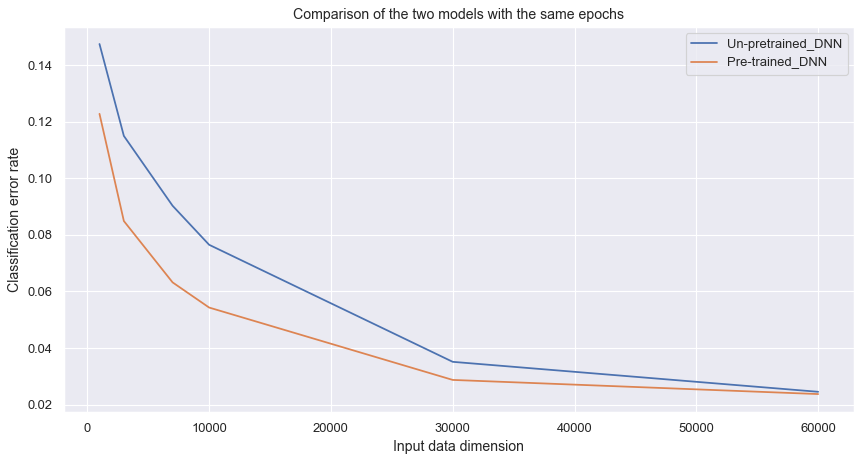

In [ ]:
plt.figure(figsize=(12,6), dpi=85)
plt.plot(input_dimension, error_model_1, label='Un-pretrained_DNN')
plt.plot(input_dimension, error_model_2, label='Pre-trained_DNN')
plt.title("Comparison of the two models with the same epochs")
plt.xlabel('Input data dimension')
plt.ylabel('Classification error rate')
plt.legend()
plt.show()

###### <font color=darkred size=5 > Conclusion </font>

Setting the number of total epochs to be the same for our neural networks doesn't change the overall performance (Figure 3 vs Figure 4). It rather increases a bit some of the classification error rate. 

#### <font  size=5 > Hyperparameters tuning </font>

This section consists of hyperparameters tuning. We use DNN with 2 hiddens layers of 500 neurons. This is one of the architecture that provides the best classification error rate according to the previous graph. We therefore pretrain our DNN with the latter architecture and try to find the best parameters based on the classification error rates. Below the hyperparameters to tune:
* Batch size : we have a list of different batch sizes
* Learning rates

We could have added a list of epochs and loop over it. 

In [ ]:
epoch = 100
learning_rate = [0.01, 0.05, 0.1, 0.5, 0.9]
learning_rate.sort()
batches = [50, 120, 500, 1000]
all_params = {'Batch_size' : [], 'Learning_rate' : [], 'Classification_error' : []}
best_params = {}
best_params['lr'] = learning_rate[0]
best_params['batches'] = batches[0]
best_params['error'] = 1

for batch in tqdm(batches):
    print('')
    print('Batch Size: {}'.format(batch))
    for lr in learning_rate:
        print('Learning Rate: {}'.format(lr))
        print('Epochs: {}'.format(epoch))
        init_DNN = DBN([784, 500, 500, 10]).pretrain_DNN(X_train, lr, epoch, batch)
        back_propagate_DNN = backpropagation(init_DNN, epoch, lr, batch, X_train, y_train)[0]
        error_rate = test_DNN(back_propagate_DNN, X_test, y_test)
        #Store all parameters
        all_params['Batch_size'].append(batch)
        all_params['Classification_error'].append(error_rate)
        all_params['Learning_rate'].append(lr)
        #print the best parameters found based on classification error rate
        if error_rate < best_params['error']:
          best_params['error'] = error_rate
          best_params['epoch'] = epoch
          best_params['batches'] = batch
          best_params['lr'] = lr
          print('New optimal parameters')
          print(pd.Series(best_params))
          print('-------------------')

  0%|          | 0/4 [00:00<?, ?it/s]


Batch Size: 50
Learning Rate: 0.01
Epochs: 100
New optimal parameters
lr           0.0100
batches     50.0000
error        0.0309
epoch      100.0000
dtype: float64
-------------------
Learning Rate: 0.05
Epochs: 100
New optimal parameters
lr           0.0500
batches     50.0000
error        0.0248
epoch      100.0000
dtype: float64
-------------------
Learning Rate: 0.1
Epochs: 100
New optimal parameters
lr           0.1000
batches     50.0000
error        0.0215
epoch      100.0000
dtype: float64
-------------------
Learning Rate: 0.5
Epochs: 100
Learning Rate: 0.9
Epochs: 100


 25%|██▌       | 1/4 [6:52:50<20:38:30, 24770.05s/it]


Batch Size: 120
Learning Rate: 0.01
Epochs: 100
Learning Rate: 0.05
Epochs: 100
Learning Rate: 0.1
Epochs: 100
Learning Rate: 0.5
Epochs: 100
Learning Rate: 0.9
Epochs: 100


 50%|█████     | 2/4 [10:08:10<9:29:47, 17093.63s/it]


Batch Size: 500
Learning Rate: 0.01
Epochs: 100
Learning Rate: 0.05
Epochs: 100
Learning Rate: 0.1
Epochs: 100
Learning Rate: 0.5
Epochs: 100
Learning Rate: 0.9
Epochs: 100


 75%|███████▌  | 3/4 [13:31:56<4:07:51, 14871.17s/it]


Batch Size: 1000
Learning Rate: 0.01
Epochs: 100
Learning Rate: 0.05
Epochs: 100
Learning Rate: 0.1
Epochs: 100
Learning Rate: 0.5
Epochs: 100
Learning Rate: 0.9
Epochs: 100


100%|██████████| 4/4 [16:00:59<00:00, 14415.00s/it]  


In [ ]:
df_all_params = pd.DataFrame(all_params)
df_all_params

,Batch_size,Learning_rate,Classification_error
0,50,0.01,0.0309
1,50,0.05,0.0248
2,50,0.10,0.0215
3,50,0.50,0.0225
4,50,0.90,0.0258
5,120,0.01,0.0419
6,120,0.05,0.0235
7,120,0.10,0.0224
8,120,0.50,0.0218
9,120,0.90,0.0297


In [ ]:
df_all_params.to_csv('all_params.csv')

###### <font color=darkred size=4 > Figure 5 </font>

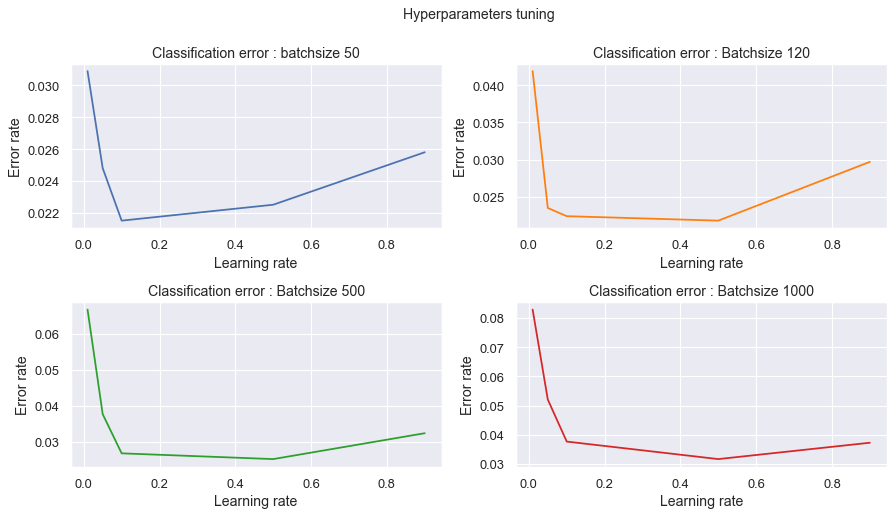

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,6), dpi=85)
fig.suptitle('Hyperparameters tuning')

ax1.plot(df_all_params['Learning_rate'][:5], df_all_params['Classification_error'][:5])
ax1.set_title("Classification error : batchsize 50")
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('Error rate')


ax2.plot(df_all_params['Learning_rate'][5:10], df_all_params['Classification_error'][5:10], 'tab:orange')
ax2.set_title("Classification error : Batchsize 120")
ax2.set_xlabel('Learning rate')
ax2.set_ylabel('Error rate')

ax3.plot(df_all_params['Learning_rate'][10:15], df_all_params['Classification_error'][10:15], 'tab:green')
ax3.set_title("Classification error : Batchsize 500")
ax3.set_xlabel('Learning rate')
ax3.set_ylabel('Error rate')

ax4.plot(df_all_params['Learning_rate'][15:], df_all_params['Classification_error'][15:], 'tab:red')
ax4.set_title("Classification error : Batchsize 1000")
ax4.set_xlabel('Learning rate')
ax4.set_ylabel('Error rate')

plt.subplots_adjust(top=0.87, bottom=0.08, left=0.10, right=0.90, hspace=0.45,
                    wspace=0.2)


###### <font color=darkred size=5 > Results </font>

Hyperparameter tuning shows that the optimal classification error rate is obtained with **100 epochs**, **0.1 learning rate** et **50 as batchsize**.

Figure 5 also shows us that when the learning rate is relatively high ($>0.5$), the classification errors obtained for small batch sizes increase. For a batch size equal to $1000$, we can see that the error rates of our DNN are higher than $3\%$ (between 4 and 8\% when the learning rate is less than or equal to $0.1$). Even if these values remain low, compared to those obtained with lower batch sizes, the overall performance of the DNN decreases. Looking more closely at the curves, we see that it is important to use high learning rates when the batch size is large (batch size $1000$, learning rate $<0.1$ vs batch size $1000$, learning rate $>0.2$).
